In [8]:
# Install Kaggle API and splitfolders for organizing dataset
!pip install -q kaggle split-folders


In [9]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"saqibkayani","key":"e5bf8c8ef8d4d3a3be55fb787be275a1"}'}

In [10]:
import os

# Move kaggle.json to correct location
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json


In [11]:
# Download from Kaggle
!kaggle datasets download -d abdallahalidev/plantvillage-dataset


Dataset URL: https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset
License(s): CC-BY-NC-SA-4.0


In [12]:
import zipfile

# Extract dataset zip
with zipfile.ZipFile("plantvillage-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/plantvillage")

print("✅ Dataset extracted to /content/plantvillage")


✅ Dataset extracted to /content/plantvillage


In [14]:
import splitfolders
import shutil

input_folder = "/content/plantvillage/plantvillage dataset/color"
output_folder = "/content/plantvillage_split"

# Clean old output if exists
if os.path.exists(output_folder):
    shutil.rmtree(output_folder)

# Perform 70% training, 20% validation, 10% testing
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .2, .1))

print("✅ Dataset split complete.")
print("📂 Classes in train folder:", len(os.listdir(os.path.join(output_folder, 'train'))))


Copying files: 54305 files [00:12, 4499.95 files/s]

✅ Dataset split complete.
📂 Classes in train folder: 38


<ipython-input-15-9ff7d6e10d82>:22: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127807 (\N{HERB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


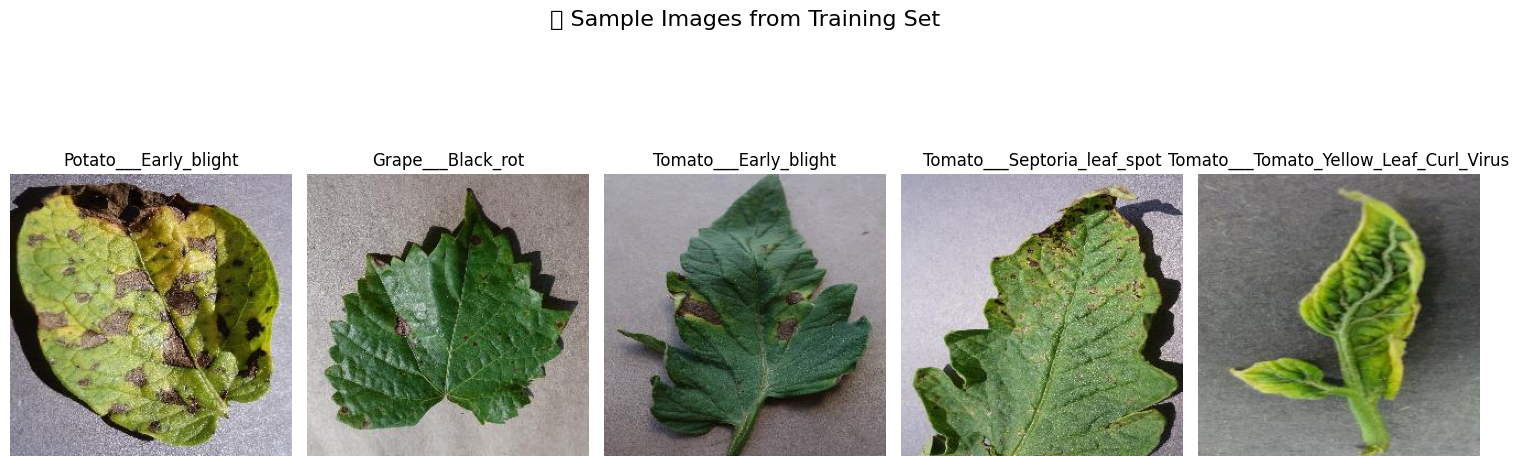

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

train_path = "/content/plantvillage_split/train"
class_names = os.listdir(train_path)

# Show 5 random images from random classes
plt.figure(figsize=(15, 6))
for i in range(5):
    class_name = random.choice(class_names)
    class_path = os.path.join(train_path, class_name)
    image_file = random.choice(os.listdir(class_path))
    img_path = os.path.join(class_path, image_file)
    img = mpimg.imread(img_path)
    plt.subplot(1, 5, i+1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.suptitle("🌿 Sample Images from Training Set", fontsize=16)
plt.tight_layout()
plt.show()


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Base directory
base_dir = "/content/plantvillage_split"

# Image dimensions and batch size
img_size = (224, 224)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load data
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, "train"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "val"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_generator = val_test_datagen.flow_from_directory(
    os.path.join(base_dir, "test"),
    target_size=img_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 37997 images belonging to 38 classes.
Found 10849 images belonging to 38 classes.
Found 5459 images belonging to 38 classes.


In [17]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

# Load MobileNetV2 without top layers
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze convolutional base

# Add custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(38, activation='softmax')(x)  # 38 classes

# Create final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,426,854 (9.26 MB)

 Trainable params: 168,870 (659.65 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Directory to save best model
checkpoint_path = "best_mobilenetv2_model.h5"

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_ckpt = ModelCheckpoint(checkpoint_path, monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, model_ckpt]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step - accuracy: 0.3639 - loss: 2.5245
Epoch 1: val_accuracy improved from -inf to 0.79924, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 468s 384ms/step - accuracy: 0.3640 - loss: 2.5239 - val_accuracy: 0.7992 - val_loss: 0.7724
Epoch 2/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.7182 - loss: 0.9868
Epoch 2: val_accuracy improved from 0.79924 to 0.86672, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 433s 364ms/step - accuracy: 0.7182 - loss: 0.9867 - val_accuracy: 0.8667 - val_loss: 0.4885
Epoch 3/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.7849 - loss: 0.7154
Epoch 3: val_accuracy improved from 0.86672 to 0.88755, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 429s 361ms/step - accuracy: 0.7849 - loss: 0.7153 - val_accuracy: 0.8875 - val_loss: 0.3833
Epoch 4/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8228 - loss: 0.5798
Epoch 4: val_accuracy improved from 0.88755 to 0.90377, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 429s 361ms/step - accuracy: 0.8228 - loss: 0.5798 - val_accuracy: 0.9038 - val_loss: 0.3242
Epoch 5/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8422 - loss: 0.5103
Epoch 5: val_accuracy improved from 0.90377 to 0.90792, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 432s 364ms/step - accuracy: 0.8423 - loss: 0.5103 - val_accuracy: 0.9079 - val_loss: 0.2986
Epoch 6/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8530 - loss: 0.4651
Epoch 6: val_accuracy improved from 0.90792 to 0.91511, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 430s 362ms/step - accuracy: 0.8530 - loss: 0.4651 - val_accuracy: 0.9151 - val_loss: 0.2760
Epoch 7/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8652 - loss: 0.4288
Epoch 7: val_accuracy improved from 0.91511 to 0.92073, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 440s 360ms/step - accuracy: 0.8652 - loss: 0.4288 - val_accuracy: 0.9207 - val_loss: 0.2530
Epoch 8/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.8722 - loss: 0.4050
Epoch 8: val_accuracy improved from 0.92073 to 0.92626, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 443s 361ms/step - accuracy: 0.8722 - loss: 0.4050 - val_accuracy: 0.9263 - val_loss: 0.2359
Epoch 9/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.8814 - loss: 0.3776
Epoch 9: val_accuracy did not improve from 0.92626
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 433s 365ms/step - accuracy: 0.8814 - loss: 0.3776 - val_accuracy: 0.9246 - val_loss: 0.2361
Epoch 10/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.8907 - loss: 0.3497
Epoch 10: val_accuracy improved from 0.92626 to 0.93004, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 430s 362ms/step - accuracy: 0.8907 - loss: 0.3497 - val_accuracy: 0.9300 - val_loss: 0.2209
Epoch 11/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.8854 - loss: 0.3522
Epoch 11: val_accuracy improved from 0.93004 to 0.93151, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 439s 370ms/step - accuracy: 0.8854 - loss: 0.3522 - val_accuracy: 0.9315 - val_loss: 0.2157
Epoch 12/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8883 - loss: 0.3434
Epoch 12: val_accuracy did not improve from 0.93151
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 435s 364ms/step - accuracy: 0.8883 - loss: 0.3433 - val_accuracy: 0.9302 - val_loss: 0.2130
Epoch 13/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step - accuracy: 0.8967 - loss: 0.3208
Epoch 13: val_accuracy improved from 0.93151 to 0.93456, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 438s 369ms/step - accuracy: 0.8967 - loss: 0.3208 - val_accuracy: 0.9346 - val_loss: 0.2011
Epoch 14/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.8975 - loss: 0.3127
Epoch 14: val_accuracy improved from 0.93456 to 0.93575, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 433s 364ms/step - accuracy: 0.8975 - loss: 0.3127 - val_accuracy: 0.9358 - val_loss: 0.1972
Epoch 15/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9024 - loss: 0.3092
Epoch 15: val_accuracy did not improve from 0.93575
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 436s 367ms/step - accuracy: 0.9024 - loss: 0.3092 - val_accuracy: 0.9333 - val_loss: 0.1967
Epoch 16/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.9029 - loss: 0.3039
Epoch 16: val_accuracy improved from 0.93575 to 0.93649, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 431s 363ms/step - accuracy: 0.9029 - loss: 0.3039 - val_accuracy: 0.9365 - val_loss: 0.1960
Epoch 17/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step - accuracy: 0.9043 - loss: 0.2975
Epoch 17: val_accuracy improved from 0.93649 to 0.93870, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 440s 371ms/step - accuracy: 0.9043 - loss: 0.2975 - val_accuracy: 0.9387 - val_loss: 0.1865
Epoch 18/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9041 - loss: 0.2942
Epoch 18: val_accuracy improved from 0.93870 to 0.94064, saving model to best_mobilenetv2_model.h5


1188/1188 ━━━━━━━━━━━━━━━━━━━━ 430s 361ms/step - accuracy: 0.9041 - loss: 0.2942 - val_accuracy: 0.9406 - val_loss: 0.1809
Epoch 19/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step - accuracy: 0.9093 - loss: 0.2791
Epoch 19: val_accuracy did not improve from 0.94064
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 439s 369ms/step - accuracy: 0.9093 - loss: 0.2791 - val_accuracy: 0.9401 - val_loss: 0.1801
Epoch 20/20
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9108 - loss: 0.2813
Epoch 20: val_accuracy did not improve from 0.94064
1188/1188 ━━━━━━━━━━━━━━━━━━━━ 433s 364ms/step - accuracy: 0.9108 - loss: 0.2813 - val_accuracy: 0.9392 - val_loss: 0.1855


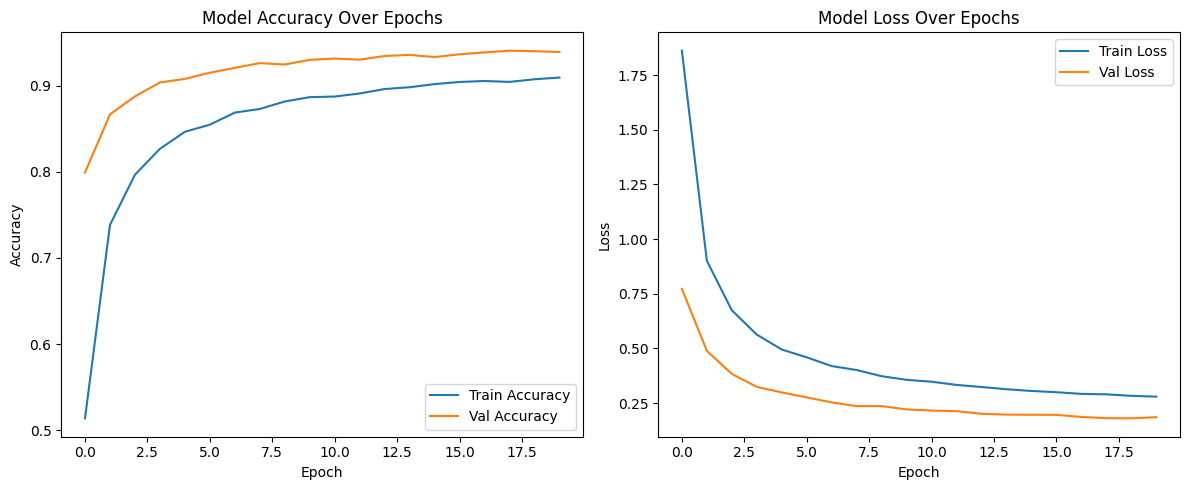

In [19]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)

print(f"\n✅ Test Accuracy: {test_accuracy:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")


171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 70ms/step - accuracy: 0.9593 - loss: 0.1312

✅ Test Accuracy: 0.9419
❌ Test Loss: 0.1743


In [21]:
# Save as .h5 (legacy but useful)
model.save('crop_disease_model.h5')

# Save in Keras native format
model.save('crop_disease_model.keras')

print("✅ Model saved successfully!")


✅ Model saved successfully!


In [22]:
# Save class indices (label encoding) to JSON
import json

label_map = train_generator.class_indices
reversed_label_map = {v: k for k, v in label_map.items()}

with open('class_labels.json', 'w') as f:
    json.dump(reversed_label_map, f)

print("✅ class_labels.json saved!")


✅ class_labels.json saved!


In [26]:
import os
import shutil
import zipfile
from pathlib import Path

# Set source and destination folders
src_folder = "/content/plantvillage_split/test"
dst_folder = "test_dataset_limited"
zip_file_name = "test_dataset_limited.zip"

# Clean up if folder already exists
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)

# Create destination
os.makedirs(dst_folder, exist_ok=True)

# Copy 20 files per class
for class_dir in os.listdir(src_folder):
    src_class_path = os.path.join(src_folder, class_dir)
    dst_class_path = os.path.join(dst_folder, class_dir)
    os.makedirs(dst_class_path, exist_ok=True)

    images = [f for f in os.listdir(src_class_path) if os.path.isfile(os.path.join(src_class_path, f))]
    for image_file in images[:20]:
        shutil.copy(os.path.join(src_class_path, image_file), dst_class_path)

print("✅ Copied 20 images per class to:", dst_folder)

# Zip the limited dataset
def zip_folder(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

zip_folder(dst_folder, zip_file_name)
print("✅ Zipped as:", zip_file_name)


✅ Copied 20 images per class to: test_dataset_limited
✅ Zipped as: test_dataset_limited.zip
